## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

In [2]:
using DelimitedFiles

Load some packages to make nice figures

In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [4]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.05
Δtobs = 0.1

0.1

Define the time span of interest

In [6]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

1000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [8]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [136]:
### Process and observation noise
σx = 1e-1
σy = 1e-3

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6], [0.001 0.0 0.0; 0.0 0.001 0.0; 0.0 0.0 0.001])

In [137]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [138]:
# Number of runs
Ne = 500

# Time span
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz63!, zeros(Nx), tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.0, 0.0, 0.0]

Create cache to store the different final solutions

In [139]:
X = zeros(Ny + Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`, and compute the associated observation vector.

In [140]:
J = ceil(Int64, (tf-t0)/Δtobs)
@inbounds for i=1:Ne
    xtmp = rand(π0)
    for j=1:J
        tspan = (t0 + (j-1)*model.Δtobs, t0 + j*model.Δtobs)
        prob = remake(prob, tspan = tspan, u0 = xtmp)
        sol = solve(prob, Tsit5(), dt = Δtdyn, dense = false, save_everystep = false)
        xtmp .= copy(sol.u[end]) 
        # Add process noise
        model.ϵx(xtmp)
    end
    
    # Store the state
    X[Ny+1:Ny+Nx,i] .= copy(xtmp)
end
# Generate the observations
observe(h, X, tf, Ny, Nx)

# Apply the observation noise
ϵy(X, 1, Ny)

In [219]:
# writedlm( "lorenzdata.csv",  X, ',')
X = readdlm( "lorenzdata.csv",  ',')

6×500 Array{Float64,2}:
 12.6981    0.930478   3.98214  13.6515  …   5.38257    9.40037  -13.654
  8.37203   1.62649    5.75284  13.2089      0.775109   3.96774  -11.2277
 36.521    10.9611    17.4395   34.3492     29.3109    33.9116    36.3547
 12.6979    0.929687   3.98188  13.6506      5.38174    9.40014  -13.6549
  8.37175   1.62558    5.75274  13.2087      0.774492   3.96771  -11.2286
 36.5206   10.9604    17.4391   34.3489  …  29.3107    33.9112    36.354

In [220]:
# Initialize the map
m = 10
S = HermiteMap(m, X; diag = true, α = 1.0e-4)

HermiteMap(10, 6, LinearTransform(6, [0.4147432940129076, 0.16516928040533463, 23.185696156541045, 0.4142537177229937, 0.16468411727530424, 23.185208293342406], [7.605649175105361 0.0 … 0.0 0.0; 0.0 8.937206142197835 … 0.0 0.0; … ; 0.0 0.0 … 8.937225951689017 0.0; 0.0 0.0 … 0.0 8.356337886751735], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 1 active features
, Map component of dimension 6 with Nψ 1 active features
])

In [221]:
Ne

300

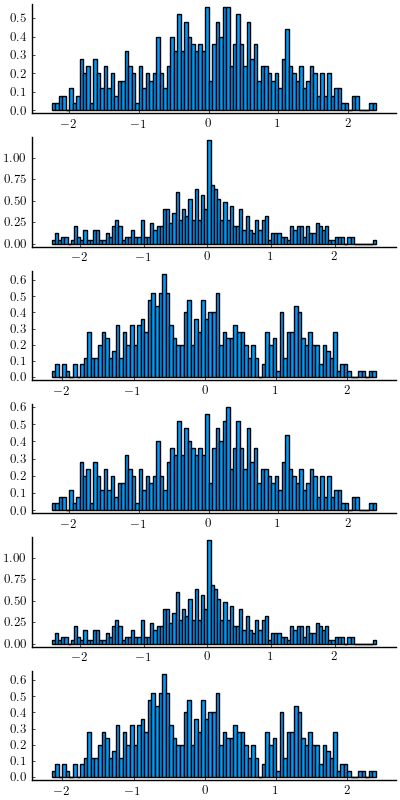

In [222]:
plt = plot(layout = grid(6,1), size = (400, 800))

for i=1:6
      histogram!(plt[i,1], sort(transform(X)[i,:]), bins = 100; normalize = :pdf, legend = false)     
end
plt
# savefig("normalized_histogram.pdf")

In [223]:
transform(X)

6×500 Array{Float64,2}:
 1.61503    0.0678095   0.469045  1.74039  …  0.653177   1.18144   -1.84978
 0.918281   0.16351     0.625215  1.45949     0.0682473  0.425477  -1.27477
 1.59583   -1.46291    -0.687649  1.33593     0.733004   1.28356    1.57594
 1.61506    0.0677698   0.469077  1.74033     0.653132   1.18148   -1.84983
 0.918301   0.163461    0.625256  1.45952     0.0682324  0.425527  -1.27481
 1.59584   -1.46294    -0.687638  1.33596  …  0.733041   1.28357    1.57591

In [224]:
getcoeff(S[3])

1-element Array{Float64,1}:
 0.0

The optimization works up to 22 active features, after the Cholesky decomposition crashes.

In [225]:
@time optimize(S, X, "kfolds"; withqr = true, verbose = true, hessprecond = true)

1 terms - Training error: 1.4018763830606684, Validation error: 1.4821871337806913
1 terms - Training error: 1.4015676367088863, Validation error: 1.4836986647681685
2 terms - Training error: 1.400924085435876, Validation error: 1.4778565751565629
3 terms - Training error: 1.3980274606082448, Validation error: 1.478248593122396
4 terms - Training error: 1.396744184144287, Validation error: 1.476408969911256
5 terms - Training error: 1.3962772193119128, Validation error: 1.4754070004757354
6 terms - Training error: 1.36355716426505, Validation error: 1.4508596231020563
7 terms - Training error: 1.3622481918670368, Validation error: 1.4490698341986197
8 terms - Training error: 1.3622246394931794, Validation error: 1.4484615370663596
9 terms - Training error: 1.362064119682257, Validation error: 1.4500501433204165
1 terms - Training error: 1.4044094408164385, Validation error: 1.4720549027576117
1 terms - Training error: 1.4044024044311827, Validation error: 1.4719277657677687
2 terms - T

Progress:  17%|██████▉                                  |  ETA: 0:00:02

8 terms - Training error: 1.3787373402519847
1 terms - Training error: 1.4081002405110596, Validation error: 1.4572917039791258
1 terms - Training error: 1.4080581775045067, Validation error: 1.4571579989580485
2 terms - Training error: 1.0733440675815513, Validation error: 1.0783767350307116
3 terms - Training error: 1.0731432376772991, Validation error: 1.0793223742659075
4 terms - Training error: 1.036795462454454, Validation error: 1.0368208416577878
5 terms - Training error: 1.0367301939901874, Validation error: 1.0370432442962738
6 terms - Training error: 1.035352493837663, Validation error: 1.033074579758946
7 terms - Training error: 1.0351855357827493, Validation error: 1.0329548585639405
8 terms - Training error: 0.7727814484714086, Validation error: 0.8003949118956468
9 terms - Training error: 0.7710103895811699, Validation error: 0.8010311623576807
1 terms - Training error: 1.3947347942418242, Validation error: 1.5107534890560672
1 terms - Training error: 1.3947091817289703,

Progress:  33%|█████████████▋                           |  ETA: 0:00:01

9 terms - Training error: 0.7554474911914053, Validation error: 0.7512411287228776
1 terms - Training error: 1.4179385332046728
1 terms - Training error: 1.417876018945938
2 terms - Training error: 1.0742529520614625
3 terms - Training error: 1.0742127244556938
4 terms - Training error: 1.0366709893963149
5 terms - Training error: 1.0365704025819875
6 terms - Training error: 0.7864349280713125
7 terms - Training error: 0.7840218763271446
8 terms - Training error: 0.7341024749119388
9 terms - Training error: 0.7336477331626619
10 terms - Training error: 0.6534919100623345
1 terms - Training error: 1.4123953552426587, Validation error: 1.4401112450527285
1 terms - Training error: 1.4016176699846712, Validation error: 1.4326570809647001
2 terms - Training error: 1.140599370187145, Validation error: 1.1239425710046942
3 terms - Training error: 1.0550975482286205, Validation error: 1.0197977442791057
4 terms - Training error: 0.9100369718004122, Validation error: 0.8230980401432921
5 terms 

Progress:  50%|████████████████████▌                    |  ETA: 0:00:01

8 terms - Training error: 0.4879149736935895, Validation error: 0.5704467767038609
9 terms - Training error: 0.47769251345351926, Validation error: 0.5597801623291082
1 terms - Training error: 1.4179385332046728
1 terms - Training error: 1.4078185756635184
2 terms - Training error: 1.1372156662345754
3 terms - Training error: 1.0479791013720638
4 terms - Training error: 0.8920086831805166
5 terms - Training error: 0.8699494167003657
6 terms - Training error: 0.8448560681046455
7 terms - Training error: 0.5201346175662024
8 terms - Training error: 0.5030282799419599
9 terms - Training error: 0.4925796008052932
10 terms - Training error: 0.4915936404496708
1 terms - Training error: 1.4018770543251673, Validation error: 1.4821844487226943
1 terms - Training error: 1.4015683271656272, Validation error: 1.4836959806782468
2 terms - Training error: 1.3985322982778914, Validation error: 1.487205751173732
3 terms - Training error: 1.3972781875288112, Validation error: 1.49444581783891
4 terms 

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

10 terms - Training error: -3.2703978422908855
1 terms - Training error: 1.4080998012786006, Validation error: 1.4572934609089623
1 terms - Training error: 1.4080577404339871, Validation error: 1.4571597567332681
2 terms - Training error: 1.0733438374548716, Validation error: 1.0783736852414463
3 terms - Training error: 1.0731430243671443, Validation error: 1.0793192668109135
4 terms - Training error: 1.0367958319073056, Validation error: 1.0368184203119768
5 terms - Training error: 1.0364012766505113, Validation error: 1.0368065962541588
6 terms - Training error: 1.0340089772343861, Validation error: 1.0373297670203059
7 terms - Training error: 1.0310556847485217, Validation error: 1.035862299624964
8 terms - Training error: 0.9552240400140796, Validation error: 0.9648534530323446
9 terms - Training error: 0.9545825918135367, Validation error: 0.966286013684114
1 terms - Training error: 1.3947342226057768, Validation error: 1.5107557756002574
1 terms - Training error: 1.39468463806950

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:00

8 terms - Training error: 0.9570252070090908
9 terms - Training error: 0.9567090168472101
10 terms - Training error: 0.9563985711905413
1 terms - Training error: 1.4123947404755195, Validation error: 1.4401137041212864
1 terms - Training error: 1.4016169744147249, Validation error: 1.432659648385565
2 terms - Training error: 1.1405985349699514, Validation error: 1.1239406561228706
3 terms - Training error: 0.9985870323612338, Validation error: 0.9912429520939906
4 terms - Training error: 0.9403698157798447, Validation error: 0.9439738401553249
5 terms - Training error: 0.9384447881059181, Validation error: 0.9416371994502728
6 terms - Training error: 0.937597580515261, Validation error: 0.9403055432511719
7 terms - Training error: 0.9202559118009801, Validation error: 0.9200165738020718
8 terms - Training error: 0.9144372112017928, Validation error: 0.9224161776151775
9 terms - Training error: -0.5997723261425851, Validation error: -0.5329064589863538
1 terms - Training error: 1.411921

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


9 terms - Training error: -0.587351948626735
10 terms - Training error: -0.6657983670245594
  1.890508 seconds (1.26 M allocations: 2.939 GiB, 8.79% gc time)


HermiteMap(10, 6, LinearTransform(6, [0.4147432940129076, 0.16516928040533463, 23.185696156541045, 0.4142537177229937, 0.16468411727530424, 23.185208293342406], [7.605649175105361 0.0 … 0.0 0.0; 0.0 8.937206142197835 … 0.0 0.0; … ; 0.0 0.0 … 8.937225951689017 0.0; 0.0 0.0 … 0.0 8.356337886751735], true), MapComponent[Map component of dimension 1 with Nψ 8 active features
, Map component of dimension 2 with Nψ 10 active features
, Map component of dimension 3 with Nψ 10 active features
, Map component of dimension 4 with Nψ 10 active features
, Map component of dimension 5 with Nψ 10 active features
, Map component of dimension 6 with Nψ 10 active features
])

In [226]:
# Conditioning number of the basis evaluation on the different samples
cond(evaluate_basis(S[1].I.f.f,  transform(X[1:1,:])))

145.69621986411786

In [227]:
stor = Storage(S[1].I.f, transform(X[1:1,:]))
q = QRscaling(stor)

QRscaling([-22.36067977499789 -0.7192395394428297 … 3.487316104131349 1.263135913615813; 0.0 -22.34910947856541 … -0.5960342430510772 2.231850829980256; … ; 0.0 0.0 … 2.3567764691736994 0.2627395987615587; 0.0 0.0 … 0.0 1.0976714496580928], [-0.04472135954999581 0.0014392237899610878 … 0.14271114743145338 -0.04496039352748301; 0.0 -0.0447445121229139 … -0.03043090009552689 0.6689149400212299; … ; 0.0 0.0 … 0.4243083775995974 -0.10156282457415762; 0.0 0.0 … 0.0 0.9110194132419898], [0.525992748576151 0.0 … 0.0 0.0; 0.0 0.3836867233680237 … 0.0 0.0; … ; 0.0 0.0 … 0.25049854676258415 0.0; 0.0 0.0 … 0.0 0.2482548267582635], [1.9011668938535267 0.0 … 0.0 0.0; 0.0 2.6062929444676732 … 0.0 0.0; … ; 0.0 0.0 … 3.992039127267965 0.0; 0.0 0.0 … 0.0 4.0281190624089795], [-11.76155541488229 -0.2759626622055458 … 0.8735676161866596 0.3135795874068345; 0.0 -8.575056586024003 … -0.1493057117050317 0.554067741147035; … ; 0.0 0.0 … 0.5903690805722659 0.06522637357308642; 0.0 0.0 … 0.0 0.2725022355723618

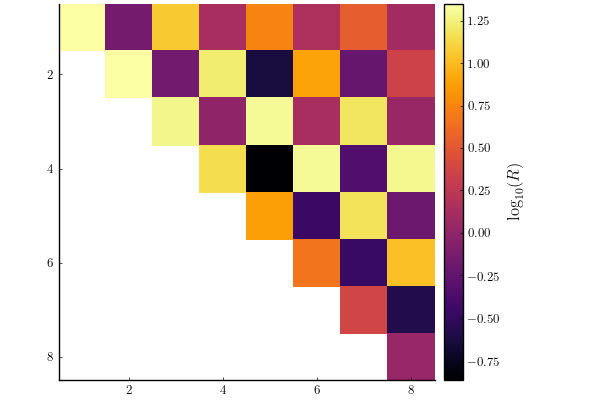

In [228]:
heatmap(log10.(abs.(q.R)), yflip =true, ratio = 1, colorbartitle = L"\log_{10}(R)")
# savefig("R_matrix.pdf")

In [229]:
cond(q.R)

111.73006949193427

In [230]:
getcoeff(S[3])

10-element Array{Float64,1}:
  33.959096143823366
 -17.58546716612034
 -16.235949022832965
   8.813689966195863
  -1.7050985733016515
  -3.56942316726535
   5.585283777672776
   0.8216500288395603
   2.0077806981409916
  -0.23594739642931903

In [231]:
cond(evaluate_basis(S[6].I.f.f, X[1:6,:]))

3.1025640154972476e12

In [233]:
P = zeros(ncoeff(S[1]), ncoeff(S[1]))
precond!(P, getcoeff(S[1]), stor, S[1], X[1:1,:])

Pqr = zeros(ncoeff(S[1]), ncoeff(S[1]))
qrprecond!(Pqr, q.U*getcoeff(S[1]), q, stor, S[1], X[1:1,:])

8×8 Array{Float64,2}:
  0.000855228   2.89794e-5    0.000445319  …  -0.0192592    0.0102198
  2.89794e-5    0.000477728   4.98451e-5      -0.00618659   0.0332823
  0.000445319   4.98451e-5    0.000963436     -0.0223839    0.0286507
  0.000119766  -0.000450165  -0.000285952      0.0105203   -0.113838
  0.0038021     0.000794907   0.00320292      -0.209096     0.192488
 -0.000917555  -0.00482533   -0.00372891   …   0.206165    -1.30508
 -0.0192592    -0.00618659   -0.0223839        1.29411     -1.55719
  0.0102198     0.0332823     0.0286507       -1.55719      8.43712

In [237]:
cond(P)

61.59830326535166

In [238]:
cond(Pqr)

31758.93211493227

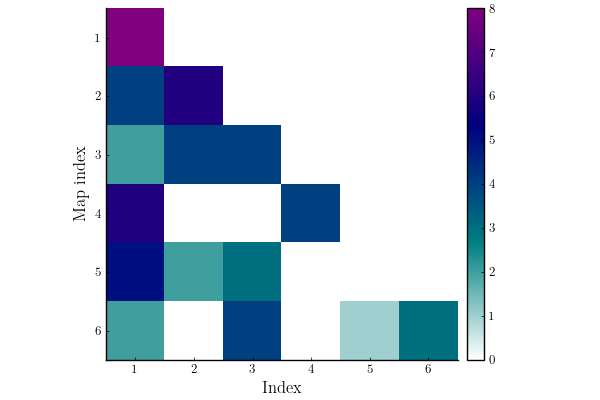

In [239]:
plot(S)

In [240]:
Ωhat = zeros(Ny + Nx, Ny + Nx)
cache = zeros(1, Ny + Nx, Ny + Nx)
for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

6×6 Array{Float64,2}:
    6.19366e12      2.17437e7  9500.11       …   2629.85    7381.15
    2.17437e7       1.51784e7  6547.25          15371.3        0.0
 9500.11         6547.25          3.50522e9        38.8805     3.18417e9
    6.14969e12      0.0           0.0               0.0        0.0
 2629.85        15371.3          38.8805        30243.6       26.145
 7381.15            0.0           3.18417e9  …     26.145      3.2675e9

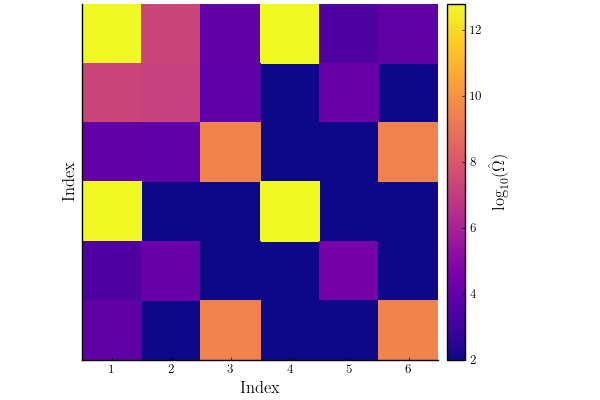

In [241]:
plt = plot()

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (2.0, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt

The rest is work in progress

Set initial condition of the true system

In [243]:
x0 = rand(model.π0);

In [244]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [250]:
Ne = 500 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×500 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
  0.0257701  0.440945  -0.840398  …  -1.11603   0.186255  -0.841999
  2.11826    0.796132  -0.595772      1.77195   2.21383   -1.14682
 -0.662958   0.100881  -1.10247      -0.29032  -1.71597    0.366678

In [251]:
smf = StochMapFilter(x->x, ϵy, S, Ny, Nx, Δtdyn, Δtobs, 2*Δtobs, false)

Stochastic Map Filter with filtered = false


In [252]:
Xsmf = seqassim(F, data, 200, model.ϵx, smf, deepcopy(X), model.Ny, model.Nx, t0);

t = 0.1
getcoeff(M[6]) = [0.7497471085835189, -0.2921518956465149, 40.03584354406773, -44.93107060596445, -0.0852537778552569, 18.446858033013868, -2.9724658953944907, -40.138361020321284, 42.652079167343814, -17.874295397927863]
t = 0.2
getcoeff(M[6]) = [0.6496355897525775, -0.4419551561430668, -7.455087978000363, -29.864763036518163, -0.011525260240135575, -3.9772982592497157, -4.036845106802647, 7.139687480816457, 26.611781492691996, 3.7078892735109292]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


t = 0.30000000000000004
getcoeff(M[6]) = [18.883823145637308, 7.914108877684279, -17.380623918295072, 8.057982944462305, -5.22900517725353, 7.927997078985445, 6.65964129684542, 0.9494948606098919, 2.5874826503957764, -1.298911951643666]
t = 0.4
getcoeff(M[6]) = [-37.0175663204591, -41.003006486420084, 29.405787221434007, 13.571956736034842, 8.346072638511696, -15.371947125259219, -86.88264746361389, 32.46430905351477, -33.337705709374134, 28.23737399394765]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


t = 0.5
getcoeff(M[6]) = [-383.8191259642699, -291.15908217374385, 383.3321805037631, 291.16137614748993, 145.19374503649487, -144.8303485800311, 0.7336935637529335]
t = 0.6000000000000001
getcoeff(M[6]) = [-383.81912596426446, -291.15908217374385, 383.33218050375854, 291.16137614748993, 145.19374503649397, -144.83034858002975, 0.733693563752933]
t = 0.7000000000000001
getcoeff(M[6]) = [-383.81912596425985, -291.1590821737439, 383.33218050375416, 291.1613761474901, 145.1937450364938, -144.83034858002975, 0.733693563752933]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


t = 0.8
getcoeff(M[6]) = [-383.81912596464826, -291.15908217373203, 383.332180504156, 291.1613761474787, 145.19374503649487, -144.8303485800261, 0.7336935637529332]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


t = 0.9
getcoeff(M[6]) = [302.12605111630216, -426.4552641364868, 323.03391122630006, -66.58832656731084, -159.20973676360796, 58.37635306462158, 7.938164444253249, 22.82213647772029]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 1.0
getcoeff(M[6]) = [-4.4046501374976295, -38.15812086977118, 36.65229143568193, -4.118000918833603, -24.24227152063534, 33.25965738004528, 17.777973146983726, 7.774421216362006]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


t = 1.1
getcoeff(M[6]) = [-10.992993312450492, -48.39244788488344, 20.563283078324552, -12.09237297359783, -10.134142071661634, 63.20187490042511, 13.18086068241807, 1.8016300318868899]
t = 1.2000000000000002
getcoeff(M[6]) = [12.08254316550755, -42.696201957660506, 10.380698511222292, 0.28214794656855025, -16.063923079399174, 28.742907719685604, -0.0862331776265495, 4.887261209825675]
t = 1.3
getcoeff(M[6]) = [11.35252291416496, -36.225006910454404, 10.915751208669056, 1.1592277644666782, -14.89292469362305, 21.33613201863551, -0.442326012091533, 2.2535882705589225]


┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/Sci

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/Sci

t = 1.4000000000000001
getcoeff(M[6]) = [1.6041640282249996, -43.59166348186522, 24.39145991464449, 0.24395444789805032, -10.109706538709883, 39.759273187107674, -0.1645157281711543, -3.7202157023717133]


┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/Sci

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/SciMLBase/dyqr8/src/integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/mat/.julia/packages/Sci

LoadError: [91mInterruptException:[39m

In [206]:
nb = 1
ne = 100
Δ = 1

1

In [202]:
data.xt

3×1000 Array{Float64,2}:
 2.19995    6.69494  17.0328  15.0845   …  -2.16126  -3.73518   -7.39222
 4.48947   14.1139   27.3883   0.19421     -3.02302  -6.17331  -12.6411
 0.767393   4.11424  27.2119  46.6231      16.6741   14.0126    15.3754

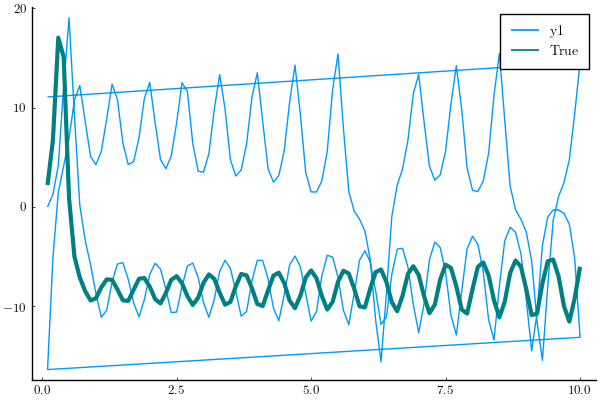

In [207]:
plot(data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,:])
plot!(data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")

In [94]:
# Plot the first component of the state over time
nb = 1
ne = 499
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "Stochastic Map Filter")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

LoadError: [91mBoundsError: attempt to access 3×201 Array{Float64,2} at index [1, 2:1:500][39m

In [33]:
# Plot the different component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsmf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mBoundsError: attempt to access 1000-element Array{Float64,1} at index [5500][39m

Talk about the benchmark of the different filters

### Benchmark of the EnKF filter

In [116]:
path = pwd()*"/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 3.8254663423276716
Ne 20 RMSE: 2.0605921219961134
Ne 40 RMSE: 0.4223537564608097
Ne 60 RMSE: 0.40146546759545937
Ne 100 RMSE: 0.3877197292448612
Ne 200 RMSE: 0.4025809532902939
 15.443304 seconds (68.89 M allocations: 6.501 GiB, 6.17% gc time)


In [55]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (10, 1.0)
  0.482682 seconds (3.47 M allocations: 329.564 MiB, 11.44% gc time)
Ne = 10
Ne 10& β 1.0 RMSE: 0.6015590736992926


Progress:  17%|██████▉                                  |  ETA: 0:00:05

(Ne, β) = (20, 1.0)
  

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

0.859515 seconds (6.59 M allocations: 631.994 MiB, 8.56% gc time)
Ne = 20
Ne 20& β 1.0 RMSE: 0.5184477645494938
(Ne, β) = (40, 1.0)
  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

1.662244 seconds (12.83 M allocations: 1.210 GiB, 8.65% gc time)
Ne = 40
Ne 40& β 1.0 RMSE: 0.4483744816193398
(Ne, β) = (60, 1.0)
  

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

2.463622 seconds (19.07 M allocations: 1.804 GiB, 8.51% gc time)
Ne = 60
Ne 60& β 1.0 RMSE: 0.4403101469791623
(Ne, β) = (100, 1.0)
  

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:02

4.334649 seconds (31.55 M allocations: 2.983 GiB, 8.49% gc time)
Ne = 100
Ne 100& β 1.0 RMSE: 0.4303647629868742
(Ne, β) = (200, 1.0)
 13.776164 seconds (62.75 M allocations: 5.935 GiB, 7.19% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4465248257137066

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


6-element Array{Any,1}:
 Metrics[Metrics(10, [0.8166106052280312, 0.8477976249831615, 0.5377435004826744, 0.2946057216215732, 0.1963372890873663, 0.1661211989653268, 0.09550122139602638, 0.10895691501209233, 0.061645037116889324, 0.1556247918798692  …  4.0942175082812975, 2.918216773645667, 2.293946056603929, 2.3368525142834664, 2.9966610036699945, 2.488711153121422, 2.060789991067101, 2.000268585410395, 2.0094430111553767, 1.633586039615903], 0.37686107778341077, 0.6015590736992926, 0.8149386709205617, [1.0125271950095414, 0.9623361052178709, 0.7792957424814254, 0.4344193482216172, 0.2873587820499424, 0.2729751953413108, 0.40382950988831384, 0.6108278943470481, 0.6592219807793599, 0.4157011617649463  …  0.6622613427311322, 0.9156031963385003, 1.1880540752197546, 1.010250360884169, 0.9055102239545725, 0.6429162631150634, 0.5592022167774022, 0.6557579770729094, 0.987851621549649, 1.1234614213819019], 0.4419068954362283, 0.5053138269227165, 0.25903240927442023, [1.0, 1.0, 0.6666666666666

In [23]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.